In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

import SALib.analyze.morris
from SALib.sample import morris

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from tqdm import tqdm

from infrasim.optimise import *
from infrasim.utils import *

mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['font.family']      = 'Arial'

In [7]:
def process_morris_results(problem,param_values,collected_results,num_levels):
    '''Process output from Morris sensitivitys
    '''
    Si = SALib.analyze.morris.analyze(problem,
                                      np.array(param_values),
                                      np.array(collected_results),
                                      print_to_console=False,
                                      num_levels=num_levels)

    sensitivity_results = pd.DataFrame.from_dict(Si)
    return sensitivity_results


def calculate_relative_influence(sensitivity_results):
    '''Return relative influence (%) of each parameter from sensitivity
    '''
    sensitivity = sensitivity_results.copy()
    sensitivity['rel'] = abs(sensitivity['mu'])/abs(sensitivity['mu']).sum()*100
    sensitivity['mu'] = sensitivity['mu']
    sensitivity = sensitivity[['names','rel']]
    sensitivity = sensitivity.sort_values(by='names',ascending=True).reset_index(drop=True)
    sensitivity.names = sensitivity.names.str.replace('_',' ')
    sensitivity.names = sensitivity.names.str.title()
    sensitivity.names = sensitivity.names.str.replace('Res','RES')
    sensitivity.names = sensitivity.names.str.replace('Coop','COO')
    sensitivity.names = sensitivity.names.str.replace('To','to')
    sensitivity.names = sensitivity.names.str.replace('Westbank','West Bank')
    return sensitivity


def read_results(path='../data/gsa_results/combined_capacities_271_generations.csv'):
    # read results
    combined_caps = pd.read_csv(path)
    # israel
    israel_results = process_morris_results(problem,
                                            param_values,
                                            combined_caps['Israel'].to_list(),
                                            num_levels)
    # jordan
    jordan_results = process_morris_results(problem,
                                            param_values,
                                            combined_caps['Jordan'].to_list(),
                                            num_levels)
    # west bank
    westbank_results = process_morris_results(problem,
                                            param_values,
                                            combined_caps['West Bank'].to_list(),
                                            num_levels)
    # gaza
    gaza_results = process_morris_results(problem,
                                            param_values,
                                            combined_caps['Gaza'].to_list(),
                                            num_levels)
    # return
    return combined_caps,israel_results,jordan_results,westbank_results,gaza_results


def min_max_avg_plot(df,ax=None):
    # line plot
    sns.lineplot(x='value',y='variable',data=df,
                 linewidth=1,zorder=10,color='firebrick',ax=ax)
    # high and low
    sns.scatterplot(x='value',y='variable',data=df[df.stat != 'average'],
                    marker='|',s=100,color='firebrick',zorder=15,ax=ax)
    # mean
    sns.scatterplot(x='value',y='variable',data=df[df.stat == 'average'],
                    marker='o',s=100,color='firebrick',zorder=15,ax=ax)

In [3]:
#File paths
nodes = '../data/nextra/spatial/network/nodes.shp'
edges = '../data/nextra/spatial/network/edges.shp'
flows = '../data/nextra/nodal_flows/processed_flows_2030.csv'

# params
count       = 1
save_iter   = 25
timesteps   = None
num_levels  = 30
N           = 30

# Set up problem for sensitivity analysis # name:[lower_bound,upper_bound]
params = {'coop_res_target'                 : [0,0.8],
          'jordan_to_westbank'              : [0,10**9],
          'jordan_to_israel'                : [0,10**9],
          'israel_to_westbank'              : [0,10**9],
          'israel_to_jordan'                : [0,10**9],
          'israel_to_gaza'                  : [0,10**9],
          #'westbank_to_israel'              : [0,0], #[0,10**9],
          'westbank_to_jordan'              : [0,10**9],
          'self_sufficiency_factor'         : [0,1.0],
         }

problem = {'num_vars'    : len(params.keys()),
           'names'       : [i for i in params.keys()],
           'bounds'      : [params[i] for i in params.keys()]
          }

# create parameter values
param_values = morris.sample(problem,N=N,
                             num_levels=num_levels,
                             local_optimization=True)

In [4]:
# Run analysis with the specified parameter values
collected_caps_israel   = []
collected_caps_jordan   = []
collected_caps_westbank = []
collected_caps_gaza     = []

for param_set in tqdm(param_values,total=len(param_values)):

    model_run = nextra(nodes,edges,flows,
                       timesteps=timesteps,
                       energy_objective=True,
                       scenario='COO',
                       super_sink=False,
                       super_source=False,
                       # params
                       coo_res_factor=param_set[0],
                       jordan_to_westbank=param_set[1],
                       jordan_to_israel=param_set[2],
                       israel_to_westbank=param_set[3],
                       israel_to_jordan=param_set[4],
                       israel_to_gaza=param_set[5],
                       #westbank_to_israel=param_set[6],
                       westbank_to_jordan=param_set[6],
                       self_sufficiency_factor=param_set[7],
                      )
    
    # build, run, and get results
    model_run.build()
    model_run.run(pprint=False)
    model_results = model_run.get_results()
    
    # get capacities
    caps = model_results.results_capacities.copy()
    caps = caps.groupby(by='territory').max().reset_index()
    
    # append collected capacities
    collected_caps_israel.append(caps.loc[caps.territory == 'Israel','value'].values[0])
    collected_caps_jordan.append(caps.loc[caps.territory == 'Jordan','value'].values[0])
    collected_caps_westbank.append(caps.loc[caps.territory == 'West Bank','value'].values[0])
    collected_caps_gaza.append(caps.loc[caps.territory == 'Gaza','value'].values[0])
    
    # make dataframes
    combined_caps = pd.DataFrame({'Israel' : collected_caps_israel,
                                  'Jordan' : collected_caps_jordan,
                                  'West Bank' : collected_caps_westbank,
                                  'Gaza' : collected_caps_gaza,})
    
    # save
    if count % save_iter == 0:
        combined_caps.to_csv('../data/gsa_results/combined_capacities_' 
                             + str(count) + '_generations.csv',index=False)
    
    # adjust counter
    count = count + 1
    
combined_caps.to_csv('../data/gsa_results/combined_capacities_' 
                             + str(count) + '_generations.csv',index=False)

  0%|                                                   | 0/270 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2022-11-03



  0%|▏                                      | 1/270 [03:24<15:15:36, 204.23s/it]

  1%|▎                                      | 2/270 [07:06<15:59:19, 214.77s/it]

  1%|▍                                      | 3/270 [10:47<16:08:44, 217.69s/it]

  1%|▌                                      | 4/270 [14:28<16:10:13, 218.85s/it]

  2%|▋                                      | 5/270 [18:12<16:15:06, 220.78s/it]

  2%|▊                                      | 6/270 [21:55<16:14:14, 221.42s/it]

  3%|█                                      | 7/270 [25:38<16:13:02, 221.99s/it]

  3%|█▏                                     | 8/270 [29:21<16:10:40, 222.29s/it]

  3%|█▎                                     | 9/270 [33:04<16:08:47, 222.71s/it]

  4%|█▍                                    | 10/270 [36:04<15:07:43, 209.48s/it]

  4%|█▌                                    | 11/270 [39:38<15:10:14, 210.87s/it]

  4%|█▋                                    | 12/270 [43:15<15:14:38, 212.71s/it]

  5%|█▊                                    | 13/270 [46:49<15:12:44, 213.09s/it]

  5%|█▉                                    | 14/270 [50:22<15:08:58, 213.04s/it]

  6%|██                                    | 15/270 [53:55<15:05:51, 213.14s/it]

  6%|██▎                                   | 16/270 [57:29<15:03:11, 213.35s/it]

  6%|██▎                                 | 17/270 [1:01:03<15:00:45, 213.62s/it]

  7%|██▍                                 | 18/270 [1:04:35<14:54:29, 212.97s/it]

  7%|██▌                                 | 19/270 [1:08:22<15:08:06, 217.08s/it]

  7%|██▋                                 | 20/270 [1:11:43<14:45:14, 212.46s/it]

  8%|██▊                                 | 21/270 [1:15:04<14:27:40, 209.08s/it]

  8%|██▉                                 | 22/270 [1:18:27<14:15:38, 207.01s/it]

  9%|███                                 | 23/270 [1:21:48<14:05:20, 205.35s/it]

  9%|███▏                                | 24/270 [1:25:09<13:56:21, 203.99s/it]

  9%|███▎                                | 25/270 [1:28:31<13:50:06, 203.29s/it]

 10%|███▍                                | 26/270 [1:31:53<13:45:36, 203.02s/it]

 10%|███▌                                | 27/270 [1:35:15<13:41:24, 202.82s/it]

 10%|███▋                                | 28/270 [1:38:49<13:50:43, 205.96s/it]

 11%|███▊                                | 29/270 [1:42:23<13:57:38, 208.54s/it]

 11%|████                                | 30/270 [1:45:56<13:59:36, 209.90s/it]

 11%|████▏                               | 31/270 [1:49:34<14:06:01, 212.39s/it]

 12%|████▎                               | 32/270 [1:53:11<14:07:31, 213.66s/it]

 12%|████▍                               | 33/270 [1:56:44<14:03:23, 213.52s/it]

 13%|████▌                               | 34/270 [2:00:19<14:00:51, 213.78s/it]

 13%|████▋                               | 35/270 [2:03:51<13:55:31, 213.33s/it]

 13%|████▊                               | 36/270 [2:07:25<13:52:35, 213.48s/it]

 14%|████▉                               | 37/270 [2:10:04<12:46:04, 197.27s/it]

 14%|█████                               | 38/270 [2:13:31<12:53:17, 199.99s/it]

 14%|█████▏                              | 39/270 [2:16:55<12:55:37, 201.46s/it]

 15%|█████▎                              | 40/270 [2:20:21<12:56:52, 202.66s/it]

 15%|█████▍                              | 41/270 [2:23:44<12:53:54, 202.77s/it]

 16%|█████▌                              | 42/270 [2:27:09<12:52:47, 203.36s/it]

 16%|█████▋                              | 43/270 [2:30:44<13:02:46, 206.90s/it]

 16%|█████▊                              | 44/270 [2:34:19<13:08:18, 209.28s/it]

 17%|██████                              | 45/270 [2:37:53<13:10:17, 210.74s/it]

 17%|██████▏                             | 46/270 [2:41:36<13:20:39, 214.46s/it]

 17%|██████▎                             | 47/270 [2:45:15<13:22:31, 215.93s/it]

 18%|██████▍                             | 48/270 [2:48:56<13:24:47, 217.51s/it]

 18%|██████▌                             | 49/270 [2:52:40<13:27:19, 219.18s/it]

 19%|██████▋                             | 50/270 [2:56:20<13:25:08, 219.58s/it]

 19%|██████▊                             | 51/270 [3:00:01<13:22:51, 219.96s/it]

 19%|██████▉                             | 52/270 [3:03:44<13:22:34, 220.89s/it]

 20%|███████                             | 53/270 [3:07:25<13:18:42, 220.84s/it]

 20%|███████▏                            | 54/270 [3:11:06<13:16:01, 221.12s/it]

 20%|███████▎                            | 55/270 [3:14:30<12:53:36, 215.89s/it]

 21%|███████▍                            | 56/270 [3:17:54<12:36:40, 212.15s/it]

 21%|███████▌                            | 57/270 [3:21:16<12:22:41, 209.21s/it]

 21%|███████▋                            | 58/270 [3:24:40<12:13:28, 207.59s/it]

 22%|███████▊                            | 59/270 [3:28:01<12:03:17, 205.67s/it]

 22%|████████                            | 60/270 [3:31:24<11:56:45, 204.79s/it]

 23%|████████▏                           | 61/270 [3:34:48<11:52:32, 204.56s/it]

 23%|████████▎                           | 62/270 [3:38:36<12:13:55, 211.71s/it]

 23%|████████▍                           | 63/270 [3:42:22<12:25:27, 216.07s/it]

 24%|████████▌                           | 64/270 [3:46:05<12:29:01, 218.16s/it]

 24%|████████▋                           | 65/270 [3:49:48<12:29:29, 219.36s/it]

 24%|████████▊                           | 66/270 [3:53:30<12:29:23, 220.41s/it]

 25%|████████▉                           | 67/270 [3:57:13<12:28:14, 221.15s/it]

 25%|█████████                           | 68/270 [4:00:57<12:26:49, 221.83s/it]

 26%|█████████▏                          | 69/270 [4:04:39<12:23:27, 221.93s/it]

 26%|█████████▎                          | 70/270 [4:07:49<11:47:46, 212.33s/it]

 26%|█████████▍                          | 71/270 [4:10:57<11:19:47, 204.96s/it]

 27%|█████████▌                          | 72/270 [4:14:06<11:00:32, 200.16s/it]

 27%|█████████▋                          | 73/270 [4:17:41<11:12:16, 204.75s/it]

 27%|█████████▊                          | 74/270 [4:21:16<11:19:11, 207.91s/it]

 28%|██████████                          | 75/270 [4:23:55<10:27:59, 193.23s/it]

 28%|██████████▍                          | 76/270 [4:26:36<9:53:35, 183.59s/it]

 29%|██████████▌                          | 77/270 [4:29:15<9:26:44, 176.19s/it]

 29%|██████████▋                          | 78/270 [4:31:55<9:07:33, 171.11s/it]

 29%|██████████▊                          | 79/270 [4:34:35<8:54:27, 167.89s/it]

 30%|██████████▉                          | 80/270 [4:37:14<8:43:19, 165.26s/it]

 30%|███████████                          | 81/270 [4:39:53<8:35:06, 163.52s/it]

 30%|███████████▏                         | 82/270 [4:43:23<9:15:16, 177.21s/it]

 31%|███████████▎                         | 83/270 [4:46:51<9:41:08, 186.46s/it]

 31%|███████████▏                        | 84/270 [4:50:36<10:14:13, 198.14s/it]

 31%|███████████▎                        | 85/270 [4:54:20<10:34:22, 205.75s/it]

 32%|███████████▍                        | 86/270 [4:58:02<10:45:57, 210.64s/it]

 32%|███████████▌                        | 87/270 [5:01:44<10:52:46, 214.02s/it]

 33%|███████████▋                        | 88/270 [5:05:27<10:58:09, 216.97s/it]

 33%|███████████▊                        | 89/270 [5:09:09<10:58:55, 218.43s/it]

 33%|████████████                        | 90/270 [5:12:52<10:58:51, 219.62s/it]

 34%|████████████▏                       | 91/270 [5:16:33<10:57:08, 220.27s/it]

 34%|████████████▎                       | 92/270 [5:20:14<10:53:29, 220.28s/it]

 34%|████████████▍                       | 93/270 [5:23:53<10:49:19, 220.11s/it]

 35%|████████████▌                       | 94/270 [5:27:35<10:46:33, 220.42s/it]

 35%|████████████▋                       | 95/270 [5:31:14<10:42:15, 220.20s/it]

 36%|████████████▊                       | 96/270 [5:34:54<10:38:00, 220.00s/it]

 36%|████████████▉                       | 97/270 [5:38:36<10:36:33, 220.77s/it]

 36%|█████████████                       | 98/270 [5:42:05<10:22:47, 217.26s/it]

 37%|█████████████▏                      | 99/270 [5:45:34<10:12:10, 214.80s/it]

 37%|█████████████▎                      | 100/270 [5:48:03<9:12:32, 195.02s/it]

 37%|█████████████▍                      | 101/270 [5:51:36<9:24:17, 200.34s/it]

 38%|█████████████▌                      | 102/270 [5:55:11<9:32:49, 204.58s/it]

 38%|█████████████▋                      | 103/270 [5:58:46<9:38:31, 207.85s/it]

 39%|█████████████▊                      | 104/270 [6:02:21<9:40:34, 209.85s/it]

 39%|██████████████                      | 105/270 [6:05:53<9:39:25, 210.70s/it]

 39%|██████████████▏                     | 106/270 [6:09:20<9:32:56, 209.61s/it]

 40%|██████████████▎                     | 107/270 [6:12:50<9:29:11, 209.52s/it]

 40%|██████████████▍                     | 108/270 [6:16:26<9:31:28, 211.66s/it]

 40%|██████████████▌                     | 109/270 [6:20:16<9:42:29, 217.08s/it]

 41%|██████████████▋                     | 110/270 [6:24:05<9:48:41, 220.76s/it]

 41%|██████████████▊                     | 111/270 [6:27:55<9:52:10, 223.46s/it]

 41%|██████████████▉                     | 112/270 [6:31:46<9:54:16, 225.67s/it]

 42%|███████████████                     | 113/270 [6:35:32<9:51:07, 225.91s/it]

 42%|███████████████▏                    | 114/270 [6:39:23<9:50:54, 227.27s/it]

 43%|███████████████▎                    | 115/270 [6:42:49<9:30:30, 220.84s/it]

 43%|███████████████▍                    | 116/270 [6:46:15<9:15:46, 216.53s/it]

 43%|███████████████▌                    | 117/270 [6:49:39<9:02:27, 212.73s/it]

 44%|███████████████▋                    | 118/270 [6:53:24<9:07:56, 216.29s/it]

 44%|███████████████▊                    | 119/270 [6:56:53<8:58:55, 214.14s/it]

 44%|████████████████                    | 120/270 [7:00:22<8:51:54, 212.76s/it]

 45%|████████████████▏                   | 121/270 [7:03:53<8:46:28, 212.00s/it]

 45%|████████████████▎                   | 122/270 [7:07:21<8:40:20, 210.95s/it]

 46%|████████████████▍                   | 123/270 [7:10:50<8:35:15, 210.31s/it]

 46%|████████████████▌                   | 124/270 [7:14:24<8:34:14, 211.33s/it]

 46%|████████████████▋                   | 125/270 [7:17:54<8:30:25, 211.21s/it]

 47%|████████████████▊                   | 126/270 [7:21:27<8:27:57, 211.65s/it]

 47%|████████████████▉                   | 127/270 [7:25:03<8:27:12, 212.82s/it]

 47%|█████████████████                   | 128/270 [7:28:37<8:24:54, 213.34s/it]

 48%|█████████████████▏                  | 129/270 [7:32:11<8:21:50, 213.55s/it]

 48%|█████████████████▎                  | 130/270 [7:35:47<8:19:44, 214.18s/it]

 49%|█████████████████▍                  | 131/270 [7:39:21<8:15:57, 214.08s/it]

 49%|█████████████████▌                  | 132/270 [7:42:57<8:13:35, 214.60s/it]

 49%|█████████████████▋                  | 133/270 [7:45:37<7:33:05, 198.43s/it]

 50%|█████████████████▊                  | 134/270 [7:48:17<7:03:33, 186.86s/it]

 50%|██████████████████                  | 135/270 [7:50:55<6:41:04, 178.26s/it]

 50%|██████████████████▏                 | 136/270 [7:54:55<7:19:12, 196.66s/it]

 51%|██████████████████▎                 | 137/270 [7:58:51<7:42:15, 208.54s/it]

 51%|██████████████████▍                 | 138/270 [8:02:49<7:57:45, 217.16s/it]

 51%|██████████████████▌                 | 139/270 [8:06:34<7:59:37, 219.68s/it]

 52%|██████████████████▋                 | 140/270 [8:09:58<7:46:00, 215.08s/it]

 52%|██████████████████▊                 | 141/270 [8:13:22<7:35:02, 211.64s/it]

 53%|██████████████████▉                 | 142/270 [8:16:47<7:27:22, 209.71s/it]

 53%|███████████████████                 | 143/270 [8:20:11<7:20:07, 207.93s/it]

 53%|███████████████████▏                | 144/270 [8:23:36<7:14:44, 207.02s/it]

 54%|███████████████████▎                | 145/270 [8:27:12<7:17:12, 209.86s/it]

 54%|███████████████████▍                | 146/270 [8:30:49<7:17:35, 211.73s/it]

 54%|███████████████████▌                | 147/270 [8:34:23<7:15:41, 212.53s/it]

 55%|███████████████████▋                | 148/270 [8:38:01<7:15:23, 214.13s/it]

 55%|███████████████████▊                | 149/270 [8:41:36<7:12:23, 214.41s/it]

 56%|████████████████████                | 150/270 [8:45:11<7:09:25, 214.71s/it]

 56%|████████████████████▏               | 151/270 [8:48:44<7:04:35, 214.08s/it]

 56%|████████████████████▎               | 152/270 [8:52:18<7:01:20, 214.24s/it]

 57%|████████████████████▍               | 153/270 [8:55:49<6:55:21, 213.01s/it]

 57%|████████████████████▌               | 154/270 [8:59:25<6:53:53, 214.08s/it]

 57%|████████████████████▋               | 155/270 [9:03:01<6:51:21, 214.62s/it]

 58%|████████████████████▊               | 156/270 [9:06:37<6:48:23, 214.94s/it]

 58%|████████████████████▉               | 157/270 [9:10:16<6:47:06, 216.16s/it]

 59%|█████████████████████               | 158/270 [9:13:51<6:42:59, 215.89s/it]

 59%|█████████████████████▏              | 159/270 [9:17:27<6:39:21, 215.87s/it]

 59%|█████████████████████▎              | 160/270 [9:21:05<6:37:06, 216.61s/it]

 60%|█████████████████████▍              | 161/270 [9:24:40<6:32:28, 216.04s/it]

 60%|█████████████████████▌              | 162/270 [9:28:15<6:28:10, 215.65s/it]

 60%|█████████████████████▋              | 163/270 [9:32:00<6:29:42, 218.53s/it]

 61%|█████████████████████▊              | 164/270 [9:35:45<6:29:36, 220.53s/it]

 61%|██████████████████████              | 165/270 [9:39:04<6:14:21, 213.92s/it]

 61%|██████████████████████▏             | 166/270 [9:42:23<6:03:24, 209.66s/it]

 62%|██████████████████████▎             | 167/270 [9:45:10<5:37:40, 196.70s/it]

 62%|██████████████████████▍             | 168/270 [9:48:07<5:24:27, 190.85s/it]

 63%|██████████████████████▌             | 169/270 [9:51:07<5:15:34, 187.47s/it]

 63%|██████████████████████▋             | 170/270 [9:54:10<5:10:30, 186.30s/it]

 63%|██████████████████████▊             | 171/270 [9:57:03<5:00:56, 182.39s/it]

 64%|██████████████████████▎            | 172/270 [10:02:26<6:06:35, 224.44s/it]

 64%|██████████████████████▍            | 173/270 [10:06:18<6:06:35, 226.76s/it]

 64%|██████████████████████▌            | 174/270 [10:10:14<6:07:17, 229.56s/it]

 65%|██████████████████████▋            | 175/270 [10:14:07<6:05:02, 230.56s/it]

 65%|██████████████████████▊            | 176/270 [10:17:32<5:49:17, 222.95s/it]

 66%|██████████████████████▉            | 177/270 [10:21:00<5:38:38, 218.48s/it]

 66%|███████████████████████            | 178/270 [10:24:30<5:31:03, 215.91s/it]

 66%|███████████████████████▏           | 179/270 [10:27:53<5:21:25, 211.93s/it]

 67%|███████████████████████▎           | 180/270 [10:31:18<5:14:39, 209.77s/it]

 67%|███████████████████████▍           | 181/270 [10:34:52<5:13:13, 211.17s/it]

 67%|███████████████████████▌           | 182/270 [10:38:28<5:11:42, 212.52s/it]

 68%|███████████████████████▋           | 183/270 [10:42:01<5:08:22, 212.68s/it]

 68%|███████████████████████▊           | 184/270 [10:45:33<5:04:39, 212.56s/it]

 69%|███████████████████████▉           | 185/270 [10:49:31<5:11:57, 220.20s/it]

 69%|████████████████████████           | 186/270 [10:53:35<5:18:11, 227.28s/it]

 69%|████████████████████████▏          | 187/270 [10:57:36<5:20:12, 231.48s/it]

 70%|████████████████████████▎          | 188/270 [11:01:43<5:22:30, 235.99s/it]

 70%|████████████████████████▌          | 189/270 [11:05:50<5:23:16, 239.47s/it]

 70%|████████████████████████▋          | 190/270 [11:09:09<5:03:03, 227.29s/it]

 71%|████████████████████████▊          | 191/270 [11:12:33<4:49:56, 220.21s/it]

 71%|████████████████████████▉          | 192/270 [11:17:03<5:05:57, 235.35s/it]

 71%|█████████████████████████          | 193/270 [11:22:04<5:27:02, 254.83s/it]

 72%|█████████████████████████▏         | 194/270 [11:26:30<5:27:06, 258.24s/it]

 72%|█████████████████████████▎         | 195/270 [11:30:32<5:16:37, 253.30s/it]

 73%|█████████████████████████▍         | 196/270 [11:34:43<5:11:43, 252.75s/it]

 73%|█████████████████████████▌         | 197/270 [11:39:18<5:15:40, 259.46s/it]

 73%|█████████████████████████▋         | 198/270 [11:44:49<5:36:56, 280.78s/it]

 74%|█████████████████████████▊         | 199/270 [11:47:36<4:51:48, 246.60s/it]

 74%|█████████████████████████▉         | 200/270 [11:50:19<4:18:31, 221.59s/it]

 74%|██████████████████████████         | 201/270 [11:53:00<3:54:05, 203.56s/it]

 75%|██████████████████████████▏        | 202/270 [11:55:43<3:36:40, 191.19s/it]

 75%|██████████████████████████▎        | 203/270 [11:58:24<3:23:32, 182.28s/it]

 76%|██████████████████████████▍        | 204/270 [12:01:06<3:13:52, 176.25s/it]

 76%|██████████████████████████▌        | 205/270 [12:04:24<3:17:53, 182.67s/it]

 76%|██████████████████████████▋        | 206/270 [12:08:18<3:31:14, 198.03s/it]

 77%|██████████████████████████▊        | 207/270 [12:12:07<3:37:40, 207.32s/it]

 77%|██████████████████████████▉        | 208/270 [12:15:38<3:35:22, 208.43s/it]

 77%|███████████████████████████        | 209/270 [12:19:09<3:32:50, 209.35s/it]

 78%|███████████████████████████▏       | 210/270 [12:22:41<3:30:05, 210.09s/it]

 78%|███████████████████████████▎       | 211/270 [12:26:12<3:26:44, 210.25s/it]

 79%|███████████████████████████▍       | 212/270 [12:29:40<3:22:35, 209.57s/it]

 79%|███████████████████████████▌       | 213/270 [12:33:33<3:25:40, 216.50s/it]

 79%|███████████████████████████▋       | 214/270 [12:37:29<3:27:33, 222.39s/it]

 80%|███████████████████████████▊       | 215/270 [12:41:19<3:26:01, 224.75s/it]

 80%|████████████████████████████       | 216/270 [12:45:11<3:24:17, 226.98s/it]

 80%|████████████████████████████▏      | 217/270 [12:48:25<3:11:45, 217.09s/it]

 81%|████████████████████████████▎      | 218/270 [12:51:37<3:01:35, 209.52s/it]

 81%|████████████████████████████▍      | 219/270 [12:54:47<2:53:06, 203.66s/it]

 81%|████████████████████████████▌      | 220/270 [12:58:37<2:56:18, 211.58s/it]

 82%|████████████████████████████▋      | 221/270 [13:02:23<2:56:18, 215.88s/it]

 82%|████████████████████████████▊      | 222/270 [13:06:10<2:55:16, 219.10s/it]

 83%|████████████████████████████▉      | 223/270 [13:10:00<2:54:15, 222.46s/it]

 83%|█████████████████████████████      | 224/270 [13:13:47<2:51:33, 223.77s/it]

 83%|█████████████████████████████▏     | 225/270 [13:17:35<2:48:53, 225.19s/it]

 84%|█████████████████████████████▎     | 226/270 [13:21:16<2:44:12, 223.92s/it]

 84%|█████████████████████████████▍     | 227/270 [13:24:53<2:39:01, 221.89s/it]

 84%|█████████████████████████████▌     | 228/270 [13:28:26<2:33:25, 219.19s/it]

 85%|█████████████████████████████▋     | 229/270 [13:32:01<2:28:52, 217.86s/it]

 85%|█████████████████████████████▊     | 230/270 [13:35:39<2:25:12, 217.81s/it]

 86%|█████████████████████████████▉     | 231/270 [13:38:36<2:13:39, 205.63s/it]

 86%|██████████████████████████████     | 232/270 [13:41:35<2:05:13, 197.72s/it]

 86%|██████████████████████████████▏    | 233/270 [13:44:33<1:58:12, 191.68s/it]

 87%|██████████████████████████████▎    | 234/270 [13:47:33<1:53:00, 188.34s/it]

 87%|██████████████████████████████▍    | 235/270 [13:50:47<1:50:47, 189.94s/it]

 87%|██████████████████████████████▌    | 236/270 [13:53:59<1:47:58, 190.54s/it]

 88%|██████████████████████████████▋    | 237/270 [13:57:12<1:45:15, 191.39s/it]

 88%|██████████████████████████████▊    | 238/270 [14:00:25<1:42:17, 191.81s/it]

 89%|██████████████████████████████▉    | 239/270 [14:03:47<1:40:37, 194.75s/it]

 89%|███████████████████████████████    | 240/270 [14:07:06<1:38:06, 196.21s/it]

 89%|███████████████████████████████▏   | 241/270 [14:10:26<1:35:23, 197.35s/it]

 90%|███████████████████████████████▎   | 242/270 [14:13:46<1:32:25, 198.05s/it]

 90%|███████████████████████████████▌   | 243/270 [14:17:41<1:34:04, 209.07s/it]

 90%|███████████████████████████████▋   | 244/270 [14:21:39<1:34:21, 217.74s/it]

 91%|███████████████████████████████▊   | 245/270 [14:25:28<1:32:12, 221.30s/it]

 91%|███████████████████████████████▉   | 246/270 [14:29:22<1:30:01, 225.05s/it]

 91%|████████████████████████████████   | 247/270 [14:33:15<1:27:12, 227.50s/it]

 92%|████████████████████████████████▏  | 248/270 [14:37:09<1:24:03, 229.23s/it]

 92%|████████████████████████████████▎  | 249/270 [14:40:26<1:16:51, 219.61s/it]

 93%|████████████████████████████████▍  | 250/270 [14:43:54<1:12:05, 216.27s/it]

 93%|████████████████████████████████▌  | 251/270 [14:47:01<1:05:40, 207.41s/it]

 93%|████████████████████████████████▋  | 252/270 [14:50:16<1:01:04, 203.58s/it]

 94%|██████████████████████████████████▋  | 253/270 [14:53:28<56:41, 200.07s/it]

 94%|██████████████████████████████████▊  | 254/270 [14:56:36<52:23, 196.47s/it]

 94%|██████████████████████████████████▉  | 255/270 [14:59:46<48:40, 194.71s/it]

 95%|███████████████████████████████████  | 256/270 [15:02:56<45:04, 193.20s/it]

 95%|███████████████████████████████████▏ | 257/270 [15:06:03<41:26, 191.29s/it]

 96%|███████████████████████████████████▎ | 258/270 [15:09:14<38:15, 191.28s/it]

 96%|███████████████████████████████████▍ | 259/270 [15:12:22<34:52, 190.22s/it]

 96%|███████████████████████████████████▋ | 260/270 [15:15:32<31:41, 190.20s/it]

 97%|███████████████████████████████████▊ | 261/270 [15:19:25<30:28, 203.21s/it]

 97%|███████████████████████████████████▉ | 262/270 [15:23:06<27:47, 208.45s/it]

 97%|████████████████████████████████████ | 263/270 [15:26:46<24:42, 211.75s/it]

 98%|████████████████████████████████████▏| 264/270 [15:30:23<21:21, 213.55s/it]

 98%|████████████████████████████████████▎| 265/270 [15:34:10<18:07, 217.58s/it]

 99%|████████████████████████████████████▍| 266/270 [15:37:55<14:38, 219.60s/it]

 99%|████████████████████████████████████▌| 267/270 [15:41:37<11:01, 220.50s/it]

 99%|████████████████████████████████████▋| 268/270 [15:45:28<07:27, 223.50s/it]

100%|████████████████████████████████████▊| 269/270 [15:49:00<03:40, 220.06s/it]

100%|█████████████████████████████████████| 270/270 [15:52:31<00:00, 211.67s/it]


In [5]:
combined_caps.to_csv('../data/gsa_results/combined_capacities_' 
                             + str(count) + '_generations.csv',index=False)

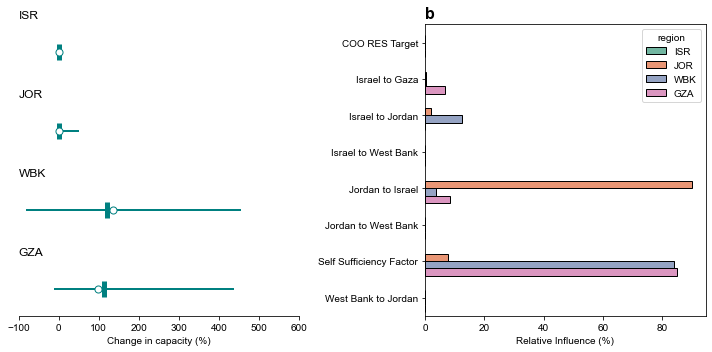

In [9]:
combined_caps,israel_results,jordan_results,westbank_results,gaza_results = read_results()
collected_caps = combined_caps.copy()

file = open('../outputs/results/model_run_results.pkl','rb')
results = pickle.load(file)
file.close()

baseline_caps = results['COO'].results_capacities.groupby(by='territory').max()['value'].to_dict()

for c in collected_caps.columns:
    collected_caps[c+'_influence'] = (collected_caps[c] - baseline_caps[c])/baseline_caps[c] * 100

collected_caps

isr = calculate_relative_influence(israel_results)
isr['region'] = 'ISR'

jor = calculate_relative_influence(jordan_results)
jor['region'] = 'JOR'

wbk = calculate_relative_influence(westbank_results)
wbk['region'] = 'WBK'

gza = calculate_relative_influence(gaza_results)
gza['region'] = 'GZA'

influence = isr.copy()
influence = influence.append(jor,ignore_index=True)
influence = influence.append(wbk,ignore_index=True)
influence = influence.append(gza,ignore_index=True)
influence['var'] = influence['names']

def custom_lineplot(df,colname,xlims,title,ax):
    x1 = df[colname].min()
    x2 = df[colname].max()
    x3 = df[colname].mean()
    x4 = df[colname].median()
    ax.plot([x1,x2],[0.5,0.5],linestyle='-',color='teal',linewidth=2,zorder=0)
    ax.scatter(x3,0.5,s=250,marker='|',color='teal',linewidth=5)
    ax.scatter(x4,0.5,s=50,marker='o',color='white',linewidth=1,edgecolor='teal')
    ax.set_xlim(xlims)
    ax.set_title(title,loc='left')
    
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(4,2,1)
ax2 = plt.subplot(4,2,3)
ax3 = plt.subplot(4,2,5)
ax4 = plt.subplot(4,2,7)
ax5 = plt.subplot(1,2,2)

xlims=[-100,600]

custom_lineplot(df=collected_caps,colname='Israel_influence',xlims=xlims,title='ISR',ax=ax1)
custom_lineplot(df=collected_caps,colname='Jordan_influence',xlims=xlims,title='JOR',ax=ax2)
custom_lineplot(df=collected_caps,colname='West Bank_influence',xlims=xlims,title='WBK',ax=ax3)
custom_lineplot(df=collected_caps,colname='Gaza_influence',xlims=xlims,title='GZA',ax=ax4)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.set_yticks([])

ax4.set_xlabel('Change in capacity (%)')

sns.barplot(x='rel',y='var',hue='region',data=influence,ax=ax5,palette='Set2',edgecolor='black')
ax5.set_ylabel('')
ax5.set_xlabel('Relative Influence (%)')
ax5.set_title('b',loc='left',fontweight='bold',fontsize=16)

f.tight_layout() 
f.savefig('../outputs/figures/global_sensitivity.pdf',bbox_inches='tight')

In [ ]:
collected_caps